In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import umap

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
folder_path = r"C:\Users\tere1\OneDrive\Escritorio\TFM\datos_img"
# Cargar las características normalizadas por Z-score
df_glcm_z = pd.read_csv(os.path.join(folder_path, "features_glcm_all_zscore.csv"))
# Cargar las características normalizadas por Min-Max
df_glcm_mm = pd.read_csv(os.path.join(folder_path, "features_glcm_all_minmax.csv"))

In [3]:
#Se eliminan los datos no numéricos: 'label' y 'filename'
df_glcm_z_cl= df_glcm_z.drop(columns=['filename', 'label'])

se va a buscar el que podría ser el mejor numero de clusteres usando BIC (Bayesian Information Criterion) y AIC (Akaike Information Criterion)

Text(0.5, 1.0, 'BIC and AIC Scores Per Number Of Clusters')

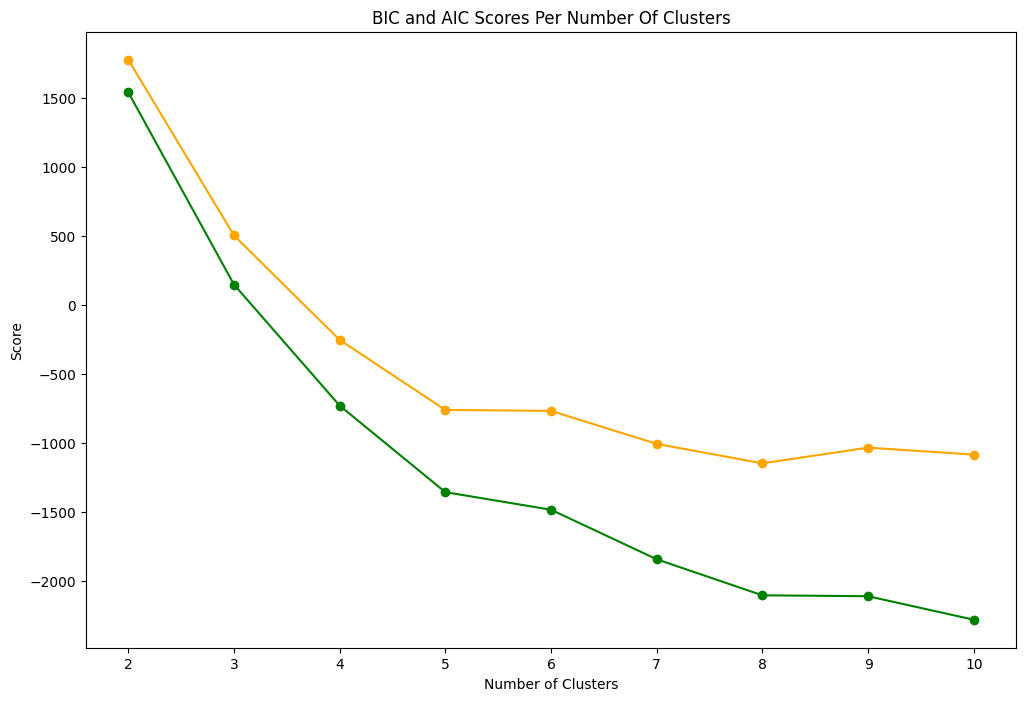

In [4]:
# Set up a range of cluster numbers to try
n_range = range(2,11)
# Create empty lists to store the BIC and AIC values
bic_score = []
aic_score = []

# Loop through the range and fit a model
for n in n_range:
    gm = GaussianMixture(n_components=n, 
                         random_state=123, 
                         n_init=10)
    gm.fit(df_glcm_z_cl)
    
    # Append the BIC and AIC to the respective lists
    bic_score.append(gm.bic(df_glcm_z_cl))
    aic_score.append(gm.aic(df_glcm_z_cl))
    
# Plot the BIC and AIC values together
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(n_range, bic_score, '-o', color='orange')
ax.plot(n_range, aic_score, '-o', color='green')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.set_title('BIC and AIC Scores Per Number Of Clusters')



In [20]:
n_components = 2  # Number of clusters
covariance_types = ['full', 'tied', 'diag', 'spherical']

gmm_models_z = {cov_type: GaussianMixture(n_components=n_components, covariance_type=cov_type)
              for cov_type in covariance_types}

for cov_type, gmm_model in gmm_models_z.items():
    gmm_model.fit(df_glcm_z_cl)

In [21]:
covariances_z = {cov_type: gmm_model.covariances_
               for cov_type, gmm_model in gmm_models_z.items()}

In [22]:
predictions_z = {cov_type: gmm_model.predict(df_glcm_z_cl)
               for cov_type, gmm_model in gmm_models_z.items()}

Covariance Matrix (full - Component):
[[ 1.48158464  1.19313423 -0.66157712 -0.16086211 -0.76973027 -0.09952815]
 [ 1.19313423  1.29965742 -1.1428101  -0.38713315 -0.94359498 -0.29074141]
 [-0.66157712 -1.1428101   1.42371619  0.59290345  0.90016882  0.47422104]
 [-0.16086211 -0.38713315  0.59290345  0.86180897 -0.0663128   0.7573861 ]
 [-0.76973027 -0.94359498  0.90016882 -0.0663128   1.3743235  -0.103891  ]
 [-0.09952815 -0.29074141  0.47422104  0.7573861  -0.103891    0.67354942]]
Covariance Matrix (tied - Component):
[ 0.85262442  0.70024111 -0.37689567 -0.19854988 -0.49774972 -0.18752975]
Covariance Matrix (diag - Component):
[0.26936138 0.18971443 0.25651626 0.9443903  0.17247574 1.04883239]
Covariance Matrix (spherical - Component):
1.8534516378417865


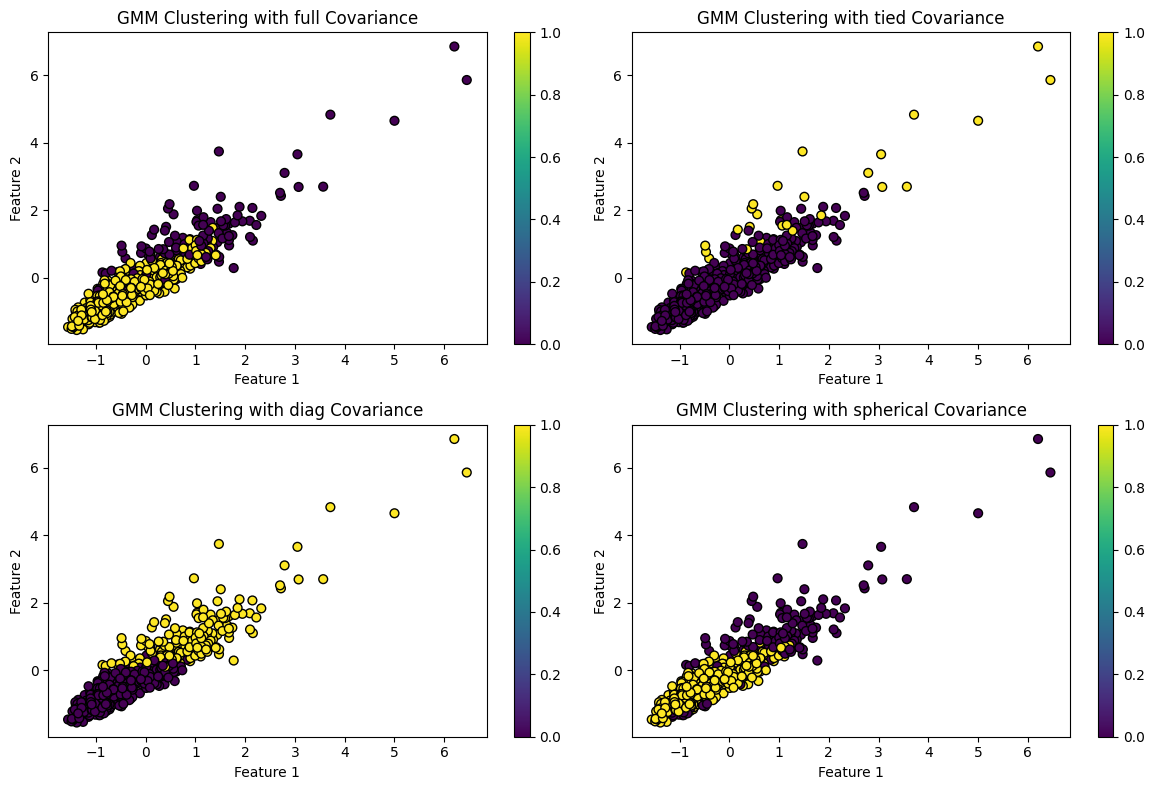

In [23]:
plt.figure(figsize=(12, 8))

for i, (cov_type, gmm_model) in enumerate(gmm_models_z.items(), 1):
    plt.subplot(2, 2, i)
    plt.scatter(df_glcm_z_cl.iloc[:, 0], df_glcm_z_cl.iloc[:, 1], c=predictions_z[cov_type], cmap='viridis', edgecolors='k', s=40)
    plt.title(f'GMM Clustering with {cov_type} Covariance')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar()
    
    print(f'Covariance Matrix ({cov_type} - Component):\n{covariances_z[cov_type][0]}')

plt.tight_layout()
plt.show()

In [24]:
print("\n--- Silhouette Scores por tipo de covarianza ---")
for cov_type in covariance_types:
    score = silhouette_score(df_glcm_z_cl, predictions_z[cov_type])
    print(f"{cov_type.capitalize()} covariance: Silhouette Score = {score:.3f}")


--- Silhouette Scores por tipo de covarianza ---
Full covariance: Silhouette Score = 0.360
Tied covariance: Silhouette Score = 0.557
Diag covariance: Silhouette Score = 0.360
Spherical covariance: Silhouette Score = 0.362


c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


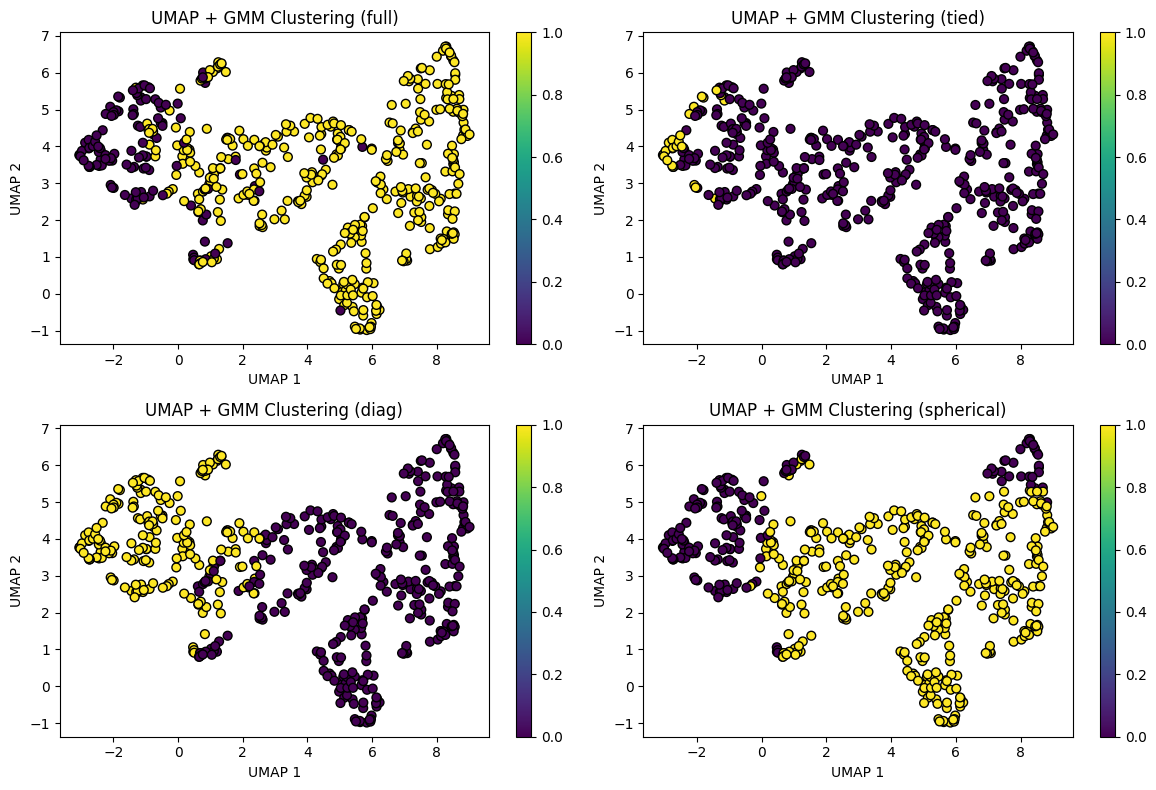

In [28]:
reducer = umap.UMAP(n_neighbors=11, n_components=2,random_state=42)
embedding = reducer.fit_transform(df_glcm_z_cl)

plt.figure(figsize=(12, 8))

for i, (cov_type, gmm_model) in enumerate(gmm_models_z.items(), 1):
    plt.subplot(2, 2, i)
    plt.scatter(embedding[:, 0], embedding[:, 1], 
                c=predictions_z[cov_type], 
                cmap='viridis', edgecolors='k', s=40)
    plt.title(f'UMAP + GMM Clustering ({cov_type})')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.colorbar()

plt.tight_layout()
plt.show()




In [29]:

df_glcm_z['predictions_z_full'] = predictions_z['full']
df_glcm_z['predictions_z_tied'] = predictions_z['tied']
df_glcm_z['predictions_z_diag'] = predictions_z['diag']
df_glcm_z['predictions_z_spherical'] = predictions_z['spherical']

# Crear las tablas de contingencia para cada tipo de covarianza
contingency_full = pd.crosstab(df_glcm_z['label'], df_glcm_z['predictions_z_full'], rownames=['Label'], colnames=['Cluster (full)'])
contingency_tied = pd.crosstab(df_glcm_z['label'], df_glcm_z['predictions_z_tied'], rownames=['Label'], colnames=['Cluster (tied)'])
contingency_diag = pd.crosstab(df_glcm_z['label'], df_glcm_z['predictions_z_diag'], rownames=['Label'], colnames=['Cluster (diag)'])
contingency_spherical = pd.crosstab(df_glcm_z['label'], df_glcm_z['predictions_z_spherical'], rownames=['Label'], colnames=['Cluster (spherical)'])

# Mostrar las tablas de contingencia
print("Contingency Table for Full Covariance:")
print(contingency_full)

print("\nContingency Table for Tied Covariance:")
print(contingency_tied)

print("\nContingency Table for Diagonal Covariance:")
print(contingency_diag)

print("\nContingency Table for Spherical Covariance:")
print(contingency_spherical)

Contingency Table for Full Covariance:
Cluster (full)    0    1
Label                   
higher           19  249
smaller         106  163

Contingency Table for Tied Covariance:
Cluster (tied)    0   1
Label                  
higher          268   0
smaller         242  27

Contingency Table for Diagonal Covariance:
Cluster (diag)    0    1
Label                   
higher          233   35
smaller         111  158

Contingency Table for Spherical Covariance:
Cluster (spherical)    0    1
Label                        
higher                35  233
smaller              128  141


minmax

In [32]:
#Se eliminan los datos no numéricos: 'label' y 'filename'
df_glcm_mm_cl= df_glcm_mm.drop(columns=['filename', 'label'])

Text(0.5, 1.0, 'BIC and AIC Scores Per Number Of Clusters')

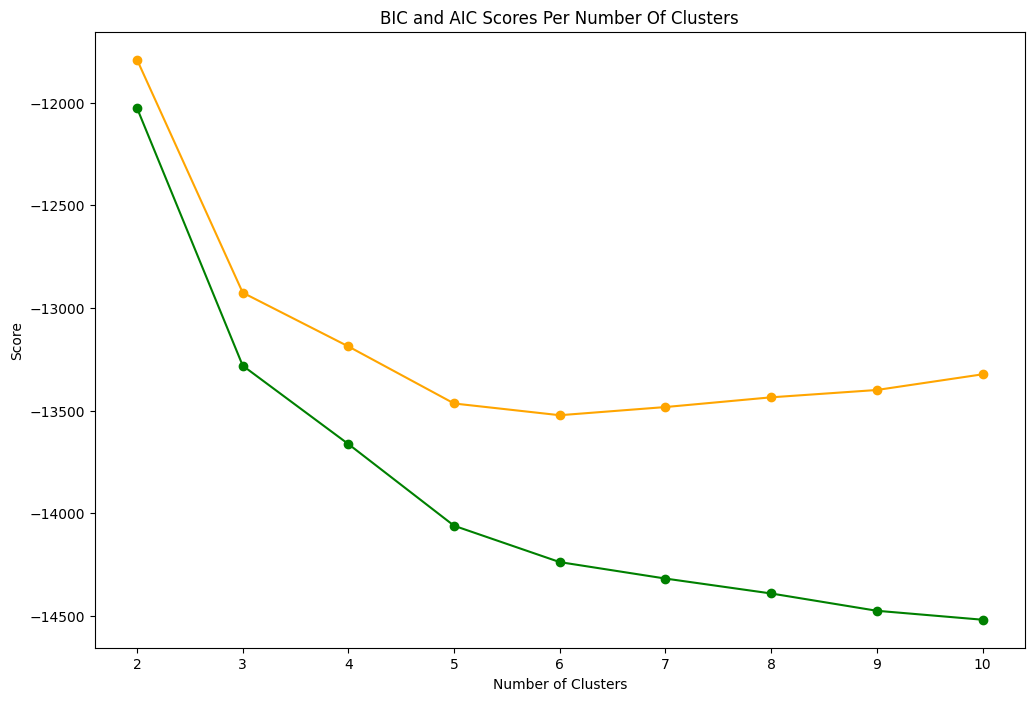

In [33]:
# Set up a range of cluster numbers to try
n_range = range(2,11)
# Create empty lists to store the BIC and AIC values
bic_score = []
aic_score = []

# Loop through the range and fit a model
for n in n_range:
    gm = GaussianMixture(n_components=n, 
                         random_state=123, 
                         n_init=10)
    gm.fit(df_glcm_mm_cl)
    
    # Append the BIC and AIC to the respective lists
    bic_score.append(gm.bic(df_glcm_mm_cl))
    aic_score.append(gm.aic(df_glcm_mm_cl))
    
# Plot the BIC and AIC values together
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(n_range, bic_score, '-o', color='orange')
ax.plot(n_range, aic_score, '-o', color='green')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.set_title('BIC and AIC Scores Per Number Of Clusters')

In [34]:
n_components = 2  # Number of clusters
covariance_types = ['full', 'tied', 'diag', 'spherical']

gmm_models_mm = {cov_type: GaussianMixture(n_components=n_components, covariance_type=cov_type)
              for cov_type in covariance_types}

for cov_type, gmm_model in gmm_models_mm.items():
    gmm_model.fit(df_glcm_mm_cl)


In [35]:
covariances_mm = {cov_type: gmm_model.covariances_
               for cov_type, gmm_model in gmm_models_mm.items()}

In [36]:
predictions_mm = {cov_type: gmm_model.predict(df_glcm_mm_cl)
               for cov_type, gmm_model in gmm_models_mm.items()}

Covariance Matrix (full - Component):
[[ 0.00690128  0.00520739 -0.00231965 -0.00096536 -0.00481498 -0.00103059]
 [ 0.00520739  0.00488366 -0.00372859 -0.00219081 -0.00456634 -0.00228494]
 [-0.00231965 -0.00372859  0.00509343  0.00408093  0.00336926  0.00423642]
 [-0.00096536 -0.00219081  0.00408093  0.0107091   0.00049482  0.01127509]
 [-0.00481498 -0.00456634  0.00336926  0.00049482  0.00563419  0.0004335 ]
 [-0.00103059 -0.00228494  0.00423642  0.01127509  0.0004335   0.01195464]]
Covariance Matrix (tied - Component):
[ 0.01325968  0.01037734 -0.00586897 -0.00272112 -0.00896002 -0.00259197]
Covariance Matrix (diag - Component):
[0.00420581 0.0026953  0.00402195 0.01144549 0.00361394 0.01292352]
Covariance Matrix (spherical - Component):
0.024902400997959137


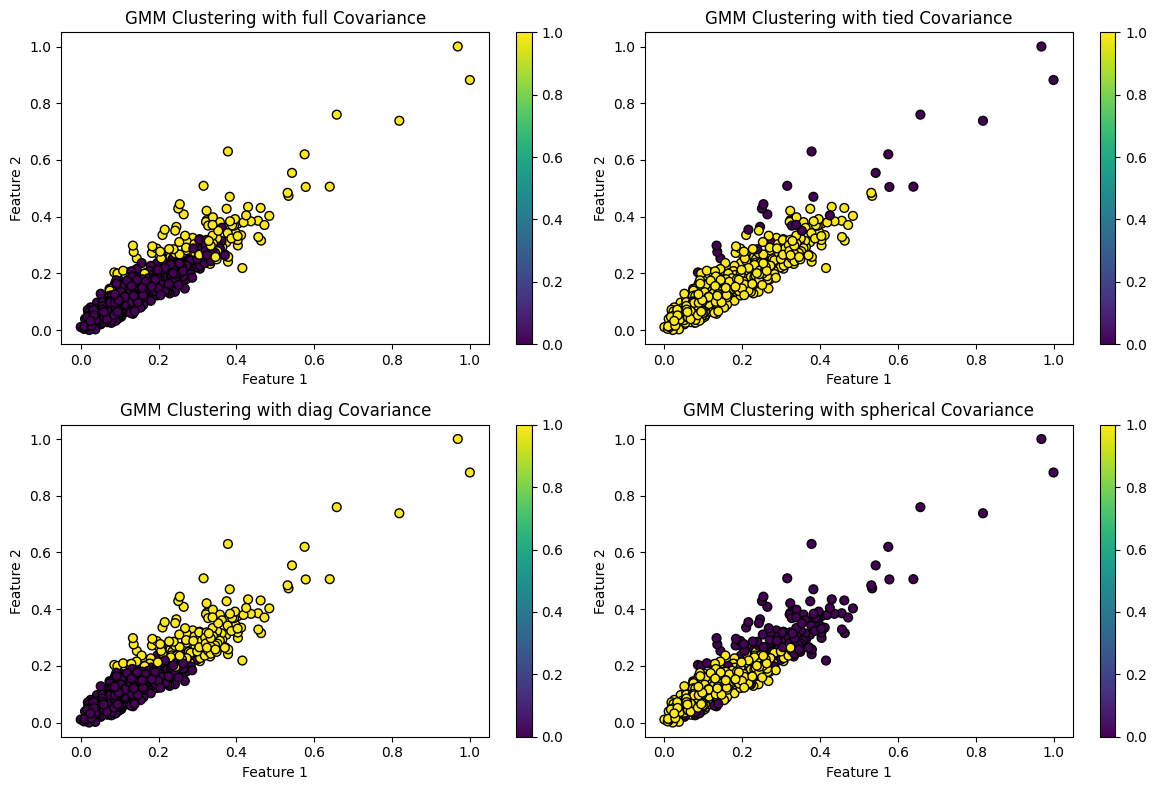

In [37]:
plt.figure(figsize=(12, 8))

for i, (cov_type, gmm_model) in enumerate(gmm_models_mm.items(), 1):
    plt.subplot(2, 2, i)
    plt.scatter(df_glcm_mm_cl.iloc[:, 0], df_glcm_mm_cl.iloc[:, 1], c=predictions_mm[cov_type], cmap='viridis', edgecolors='k', s=40)
    plt.title(f'GMM Clustering with {cov_type} Covariance')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar()
    
    print(f'Covariance Matrix ({cov_type} - Component):\n{covariances_mm[cov_type][0]}')

plt.tight_layout()
plt.show()

In [38]:
print("\n--- Silhouette Scores por tipo de covarianza ---")
for cov_type in covariance_types:
    score = silhouette_score(df_glcm_mm_cl, predictions_mm[cov_type])
    print(f"{cov_type.capitalize()} covariance: Silhouette Score = {score:.3f}")


--- Silhouette Scores por tipo de covarianza ---
Full covariance: Silhouette Score = 0.392
Tied covariance: Silhouette Score = 0.575
Diag covariance: Silhouette Score = 0.379
Spherical covariance: Silhouette Score = 0.376


c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


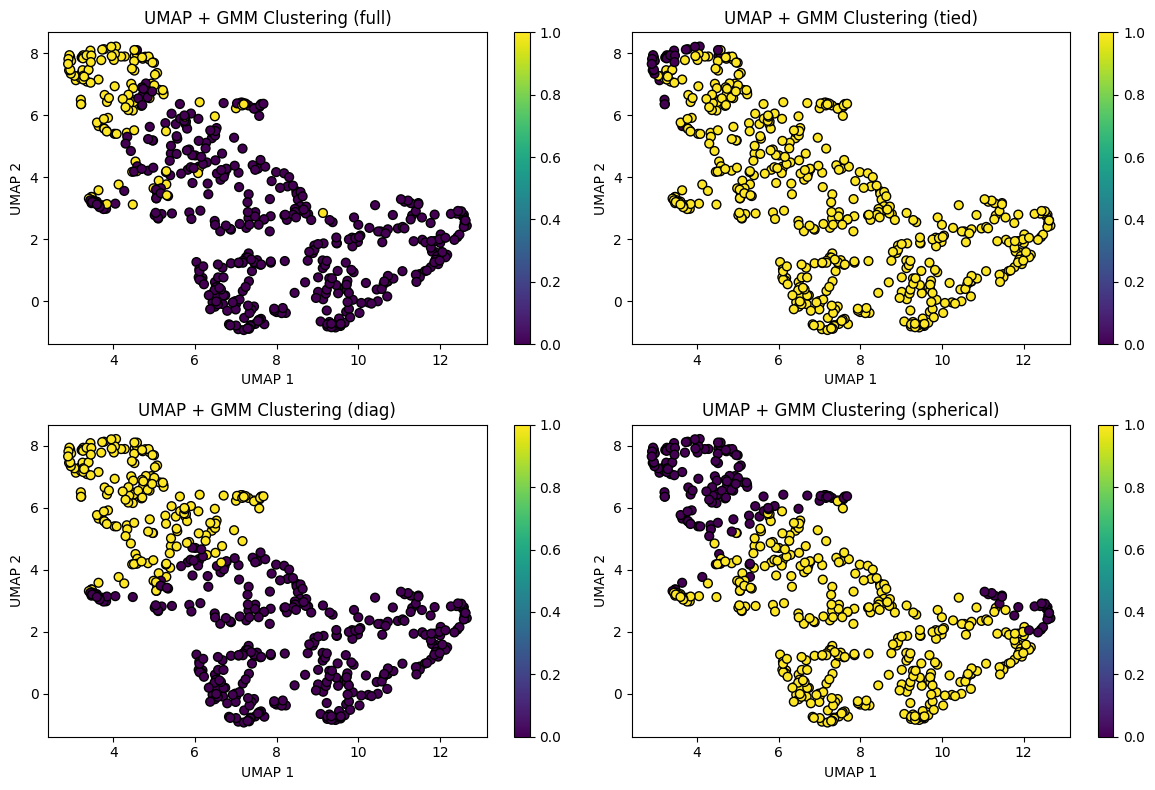

In [39]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_glcm_mm_cl)

plt.figure(figsize=(12, 8))

for i, (cov_type, gmm_model) in enumerate(gmm_models_mm.items(), 1):
    plt.subplot(2, 2, i)
    plt.scatter(embedding[:, 0], embedding[:, 1], 
                c=predictions_mm[cov_type], 
                cmap='viridis', edgecolors='k', s=40)
    plt.title(f'UMAP + GMM Clustering ({cov_type})')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.colorbar()

plt.tight_layout()
plt.show()


In [40]:
df_glcm_mm['predictions_z_full'] = predictions_mm['full']
df_glcm_mm['predictions_z_tied'] = predictions_mm['tied']
df_glcm_mm['predictions_z_diag'] = predictions_mm['diag']
df_glcm_mm['predictions_z_spherical'] = predictions_mm['spherical']

# Crear las tablas de contingencia para cada tipo de covarianza
contingency_full = pd.crosstab(df_glcm_mm['label'], df_glcm_mm['predictions_z_full'], rownames=['Label'], colnames=['Cluster (full)'])
contingency_tied = pd.crosstab(df_glcm_mm['label'], df_glcm_mm['predictions_z_tied'], rownames=['Label'], colnames=['Cluster (tied)'])
contingency_diag = pd.crosstab(df_glcm_mm['label'], df_glcm_mm['predictions_z_diag'], rownames=['Label'], colnames=['Cluster (diag)'])
contingency_spherical = pd.crosstab(df_glcm_mm['label'], df_glcm_mm['predictions_z_spherical'], rownames=['Label'], colnames=['Cluster (spherical)'])

# Mostrar las tablas de contingencia
print("Contingency Table for Full Covariance:")
print(contingency_full)

print("\nContingency Table for Tied Covariance:")
print(contingency_tied)

print("\nContingency Table for Diagonal Covariance:")
print(contingency_diag)

print("\nContingency Table for Spherical Covariance:")
print(contingency_spherical)

Contingency Table for Full Covariance:
Cluster (full)    0    1
Label                   
higher          253   15
smaller         164  105

Contingency Table for Tied Covariance:
Cluster (tied)   0    1
Label                  
higher           0  268
smaller         27  242

Contingency Table for Diagonal Covariance:
Cluster (diag)    0    1
Label                   
higher          233   35
smaller         112  157

Contingency Table for Spherical Covariance:
Cluster (spherical)    0    1
Label                        
higher                33  235
smaller              137  132


reduccion de dimensionalidad umap...

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Covariance Matrix (full - Component 0):
[[3.63797149 1.10033224]
 [1.10033224 1.47368522]]
Covariance Matrix (tied - Component 0):
[ 2.84487584 -0.03255046]
Covariance Matrix (diag - Component 0):
[3.76670896 1.82300997]
Covariance Matrix (spherical - Component 0):
2.8307545555619407


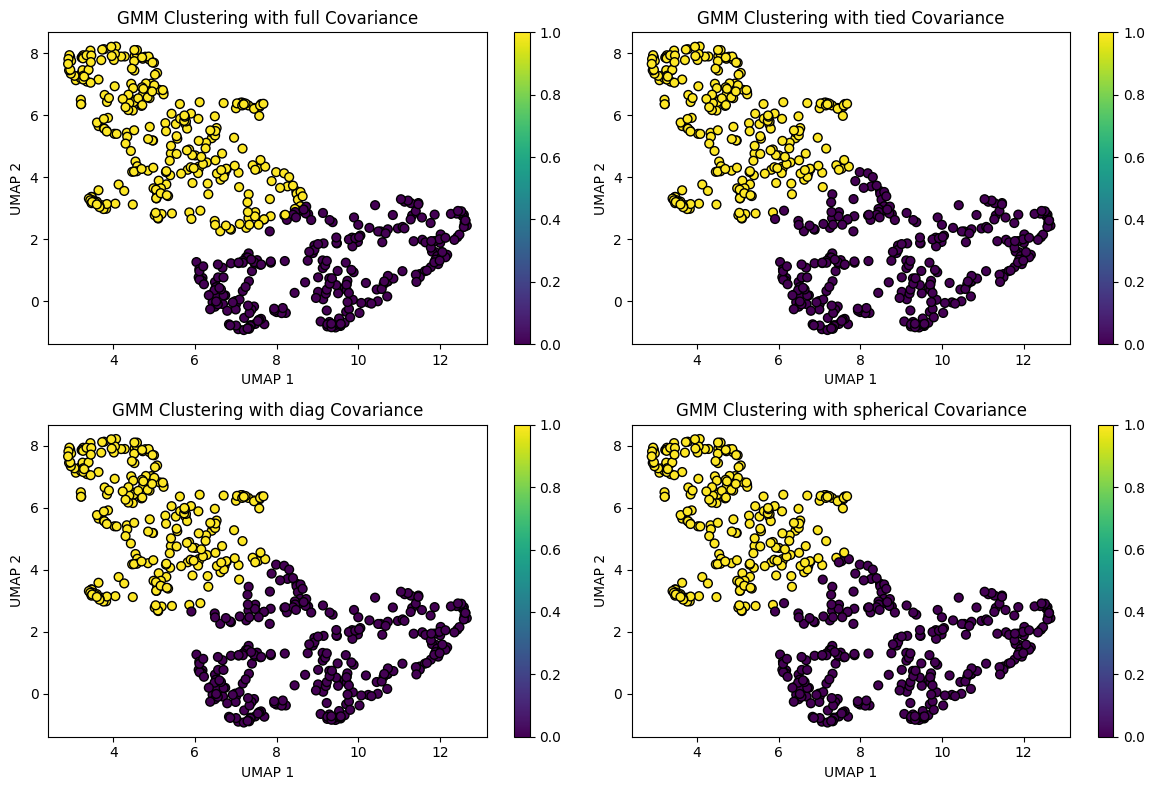

In [42]:
reducer = umap.UMAP(n_neighbors=15, n_components=2, random_state=42)
model_umap_glcm_mm = reducer.fit_transform(df_glcm_mm_cl)

# Clustering con GMM
n_components = 2
covariance_types = ['full', 'tied', 'diag', 'spherical']

gmm_models_mm_umap = {
    cov_type: GaussianMixture(n_components=n_components, covariance_type=cov_type, random_state=42)
    for cov_type in covariance_types
}

# Entrenar modelos
for cov_type, gmm_model in gmm_models_mm_umap.items():
    gmm_model.fit(model_umap_glcm_mm)

# Obtener matrices de covarianza
covariances_mm_umap = {
    cov_type: gmm_model.covariances_ for cov_type, gmm_model in gmm_models_mm_umap.items()
}

# Obtener predicciones
predictions_mm_umap = {
    cov_type: gmm_model.predict(model_umap_glcm_mm) for cov_type, gmm_model in gmm_models_mm_umap.items()
}

# Graficar
plt.figure(figsize=(12, 8))
for i, cov_type in enumerate(covariance_types, 1):
    plt.subplot(2, 2, i)
    plt.scatter(
        model_umap_glcm_mm[:, 0], model_umap_glcm_mm[:, 1],
        c=predictions_mm_umap[cov_type],
        cmap='viridis', edgecolors='k', s=40
    )
    plt.title(f'GMM Clustering with {cov_type} Covariance')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.colorbar()

    print(f'Covariance Matrix ({cov_type} - Component 0):\n{covariances_mm_umap[cov_type][0]}')

plt.tight_layout()
plt.show()

In [43]:
df_glcm_mm['gmm_umap_full'] = predictions_mm_umap['full']
df_glcm_mm['gmm_umap_tied'] = predictions_mm_umap['tied']
df_glcm_mm['gmm_umap_diag'] = predictions_mm_umap['diag']
df_glcm_mm['gmm_umap_spherical'] = predictions_mm_umap['spherical']

contingency_umap_full = pd.crosstab(df_glcm_mm['label'], df_glcm_mm['gmm_umap_full'], rownames=['Label'], colnames=['Cluster (UMAP - full)'])
contingency_umap_tied = pd.crosstab(df_glcm_mm['label'], df_glcm_mm['gmm_umap_tied'], rownames=['Label'], colnames=['Cluster (UMAP - tied)'])
contingency_umap_diag = pd.crosstab(df_glcm_mm['label'], df_glcm_mm['gmm_umap_diag'], rownames=['Label'], colnames=['Cluster (UMAP - diag)'])
contingency_umap_spherical = pd.crosstab(df_glcm_mm['label'], df_glcm_mm['gmm_umap_spherical'], rownames=['Label'], colnames=['Cluster (UMAP - spherical)'])

print("Contingency Table for UMAP + Full Covariance:")
print(contingency_umap_full)

print("\nContingency Table for UMAP + Tied Covariance:")
print(contingency_umap_tied)

print("\nContingency Table for UMAP + Diagonal Covariance:")
print(contingency_umap_diag)

print("\nContingency Table for UMAP + Spherical Covariance:")
print(contingency_umap_spherical)


Contingency Table for UMAP + Full Covariance:
Cluster (UMAP - full)    0    1
Label                          
higher                 186   82
smaller                 64  205

Contingency Table for UMAP + Tied Covariance:
Cluster (UMAP - tied)    0    1
Label                          
higher                 209   59
smaller                 80  189

Contingency Table for UMAP + Diagonal Covariance:
Cluster (UMAP - diag)    0    1
Label                          
higher                 209   59
smaller                 79  190

Contingency Table for UMAP + Spherical Covariance:
Cluster (UMAP - spherical)    0    1
Label                               
higher                      212   56
smaller                      81  188


In [52]:
# Calcular silueta para cada tipo de covarianza usando UMAP
for cov_type in covariance_types:
    labels = predictions_mm_umap[cov_type]
    score = silhouette_score(model_umap_glcm_mm, labels)
    print(f"Silhouette Score (UMAP + GMM {cov_type}): {score:.4f}")

Silhouette Score (UMAP + GMM full): 0.5079
Silhouette Score (UMAP + GMM tied): 0.5415
Silhouette Score (UMAP + GMM diag): 0.5420
Silhouette Score (UMAP + GMM spherical): 0.5399


c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Covariance Matrix (full - Component 0):
[[2.82277167 2.24906196]
 [2.24906196 3.24323514]]
Covariance Matrix (tied - Component 0):
[3.23463019 0.71071386]
Covariance Matrix (diag - Component 0):
[4.02227345 2.86950081]
Covariance Matrix (spherical - Component 0):
3.3886741645980214


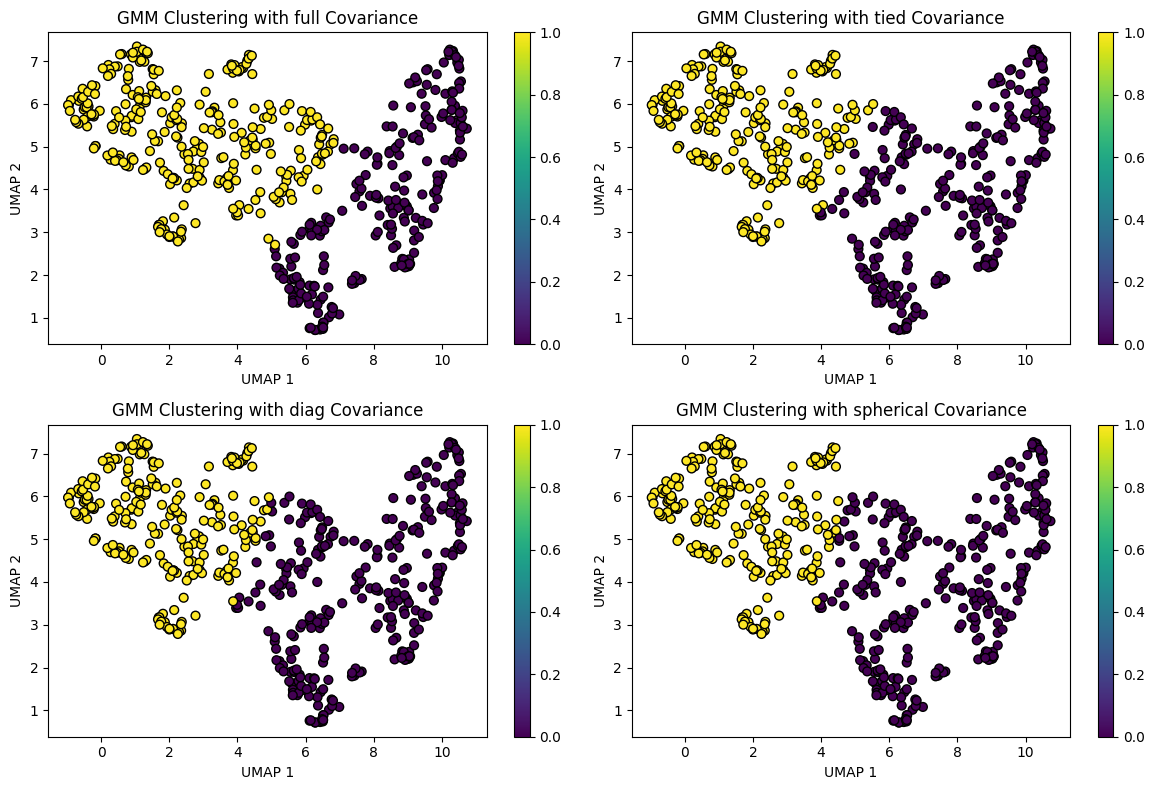

In [47]:
reducer = umap.UMAP(n_neighbors=15, n_components=2, random_state=42)
model_umap_glcm_z = reducer.fit_transform(df_glcm_z_cl)

# Clustering con GMM
n_components = 2
covariance_types = ['full', 'tied', 'diag', 'spherical']

gmm_models_z_umap = {
    cov_type: GaussianMixture(n_components=n_components, covariance_type=cov_type, random_state=42)
    for cov_type in covariance_types
}

# Entrenar modelos
for cov_type, gmm_model in gmm_models_z_umap.items():
    gmm_model.fit(model_umap_glcm_z)

# Obtener matrices de covarianza
covariances_z_umap = {
    cov_type: gmm_model.covariances_ for cov_type, gmm_model in gmm_models_z_umap.items()
}

# Obtener predicciones
predictions_z_umap = {
    cov_type: gmm_model.predict(model_umap_glcm_z) for cov_type, gmm_model in gmm_models_z_umap.items()
}

# Graficar
plt.figure(figsize=(12, 8))
for i, cov_type in enumerate(covariance_types, 1):
    plt.subplot(2, 2, i)
    plt.scatter(
        model_umap_glcm_z[:, 0], model_umap_glcm_z[:, 1],
        c=predictions_z_umap[cov_type],
        cmap='viridis', edgecolors='k', s=40
    )
    plt.title(f'GMM Clustering with {cov_type} Covariance')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.colorbar()

    print(f'Covariance Matrix ({cov_type} - Component 0):\n{covariances_z_umap[cov_type][0]}')

plt.tight_layout()
plt.show()

In [48]:
df_glcm_z['gmm_umap_full'] = predictions_mm_umap['full']
df_glcm_z['gmm_umap_tied'] = predictions_mm_umap['tied']
df_glcm_z['gmm_umap_diag'] = predictions_mm_umap['diag']
df_glcm_z['gmm_umap_spherical'] = predictions_mm_umap['spherical']

contingency_umap_full = pd.crosstab(df_glcm_z['label'], df_glcm_z['gmm_umap_full'], rownames=['Label'], colnames=['Cluster (UMAP - full)'])
contingency_umap_tied = pd.crosstab(df_glcm_z['label'], df_glcm_z['gmm_umap_tied'], rownames=['Label'], colnames=['Cluster (UMAP - tied)'])
contingency_umap_diag = pd.crosstab(df_glcm_z['label'], df_glcm_z['gmm_umap_diag'], rownames=['Label'], colnames=['Cluster (UMAP - diag)'])
contingency_umap_spherical = pd.crosstab(df_glcm_z['label'], df_glcm_z['gmm_umap_spherical'], rownames=['Label'], colnames=['Cluster (UMAP - spherical)'])

print("Contingency Table for UMAP + Full Covariance:")
print(contingency_umap_full)

print("\nContingency Table for UMAP + Tied Covariance:")
print(contingency_umap_tied)

print("\nContingency Table for UMAP + Diagonal Covariance:")
print(contingency_umap_diag)

print("\nContingency Table for UMAP + Spherical Covariance:")
print(contingency_umap_spherical)

Contingency Table for UMAP + Full Covariance:
Cluster (UMAP - full)    0    1
Label                          
higher                 186   82
smaller                 64  205

Contingency Table for UMAP + Tied Covariance:
Cluster (UMAP - tied)    0    1
Label                          
higher                 209   59
smaller                 80  189

Contingency Table for UMAP + Diagonal Covariance:
Cluster (UMAP - diag)    0    1
Label                          
higher                 209   59
smaller                 79  190

Contingency Table for UMAP + Spherical Covariance:
Cluster (UMAP - spherical)    0    1
Label                               
higher                      212   56
smaller                      81  188


In [50]:

# Calcular silueta para cada tipo de covarianza usando UMAP
for cov_type in covariance_types:
    labels = predictions_z_umap[cov_type]
    score = silhouette_score(model_umap_glcm_z, labels)
    print(f"Silhouette Score (UMAP + GMM {cov_type}): {score:.4f}")


Silhouette Score (UMAP + GMM full): 0.4863
Silhouette Score (UMAP + GMM tied): 0.5275
Silhouette Score (UMAP + GMM diag): 0.5260
Silhouette Score (UMAP + GMM spherical): 0.5233


Sin realizar una reducción de la dimensionalidad no se obtienen clusteres que dividan más o menos las imágenes higher y smaller, pero una vez que se hace umap si.